# Research question 3 - topic detection preprocessing

## Setups

In [1]:
import numpy as np
import pandas as pd
import pickle
from pprint import pprint

# Gensim
import gensim
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

### Styles

In [4]:
def set_plot_styles(styles):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.style.use(styles)
    
set_plot_styles(['mplstyle.config'])
color = sns.color_palette('tab20')

### Read data

In [5]:
def read_data():
    western_df = pd.read_pickle('western_df_sentiment.pkl')
    non_western_df = pd.read_pickle('non_western_df_sentiment.pkl')
    western_df['type'] = 'Western'
    non_western_df['type'] = 'Non-Western'
    return pd.concat([western_df, non_western_df]).reset_index(drop=True)

In [6]:
data = read_data()

In [7]:
data.shape

(3557399, 26)

In [8]:
data.head()

,id,date,comments,host_id,neighbourhood_cleansed,city,latitude,longitude,number_of_reviews,first_review,...,comments_expanded,comments_cleaned,review_word_count,year,sentiment_from_rating,sentiment_reviews,sentiment_reviews_textblob,comment_to_sentences,sentiment_sentences,type
0,13913,2010-08-18,My girlfriend and I hadn't known Alina before ...,54730,Islington,London,51.56802,-0.11121,21,2010-08-18,...,My girlfriend and I had not known Alina before...,My girlfriend and I had not known Alina before...,152,2010,pos,1,1,[My girlfriend and I had not known Alina befor...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1]",Western
1,13913,2011-07-11,Alina was a really good host. The flat is clea...,54730,Islington,London,51.56802,-0.11121,21,2010-08-18,...,Alina was a really good host. The flat is clea...,Alina was a really good host. The flat is clea...,31,2011,pos,1,1,"[Alina was a really good host., The flat is cl...","[0, 0, 0]",Western
2,13913,2011-09-13,Alina is an amazing host. She made me feel rig...,54730,Islington,London,51.56802,-0.11121,21,2010-08-18,...,Alina is an amazing host. She made me feel rig...,Alina is an amazing host. She made me feel rig...,70,2011,pos,1,1,"[Alina is an amazing host., She made me feel r...","[1, 0, 1, 1, 0, 0, 1]",Western
3,13913,2011-10-03,"Alina's place is so nice, the room is big and ...",54730,Islington,London,51.56802,-0.11121,21,2010-08-18,...,"Alina's place is so nice, the room is big and ...",Alina s place is so nice the room is big and c...,87,2011,pos,1,1,[Alina s place is so nice the room is big and ...,"[1, 1, 0, 1]",Western
4,13913,2011-10-09,"Nice location in Islington area, good for shor...",54730,Islington,London,51.56802,-0.11121,21,2010-08-18,...,"Nice location in Islington area, good for shor...",Nice location in Islington area good for short...,17,2011,pos,1,1,[Nice location in Islington area good for shor...,"[1, 1]",Western


### Plot distribution of reviews word count

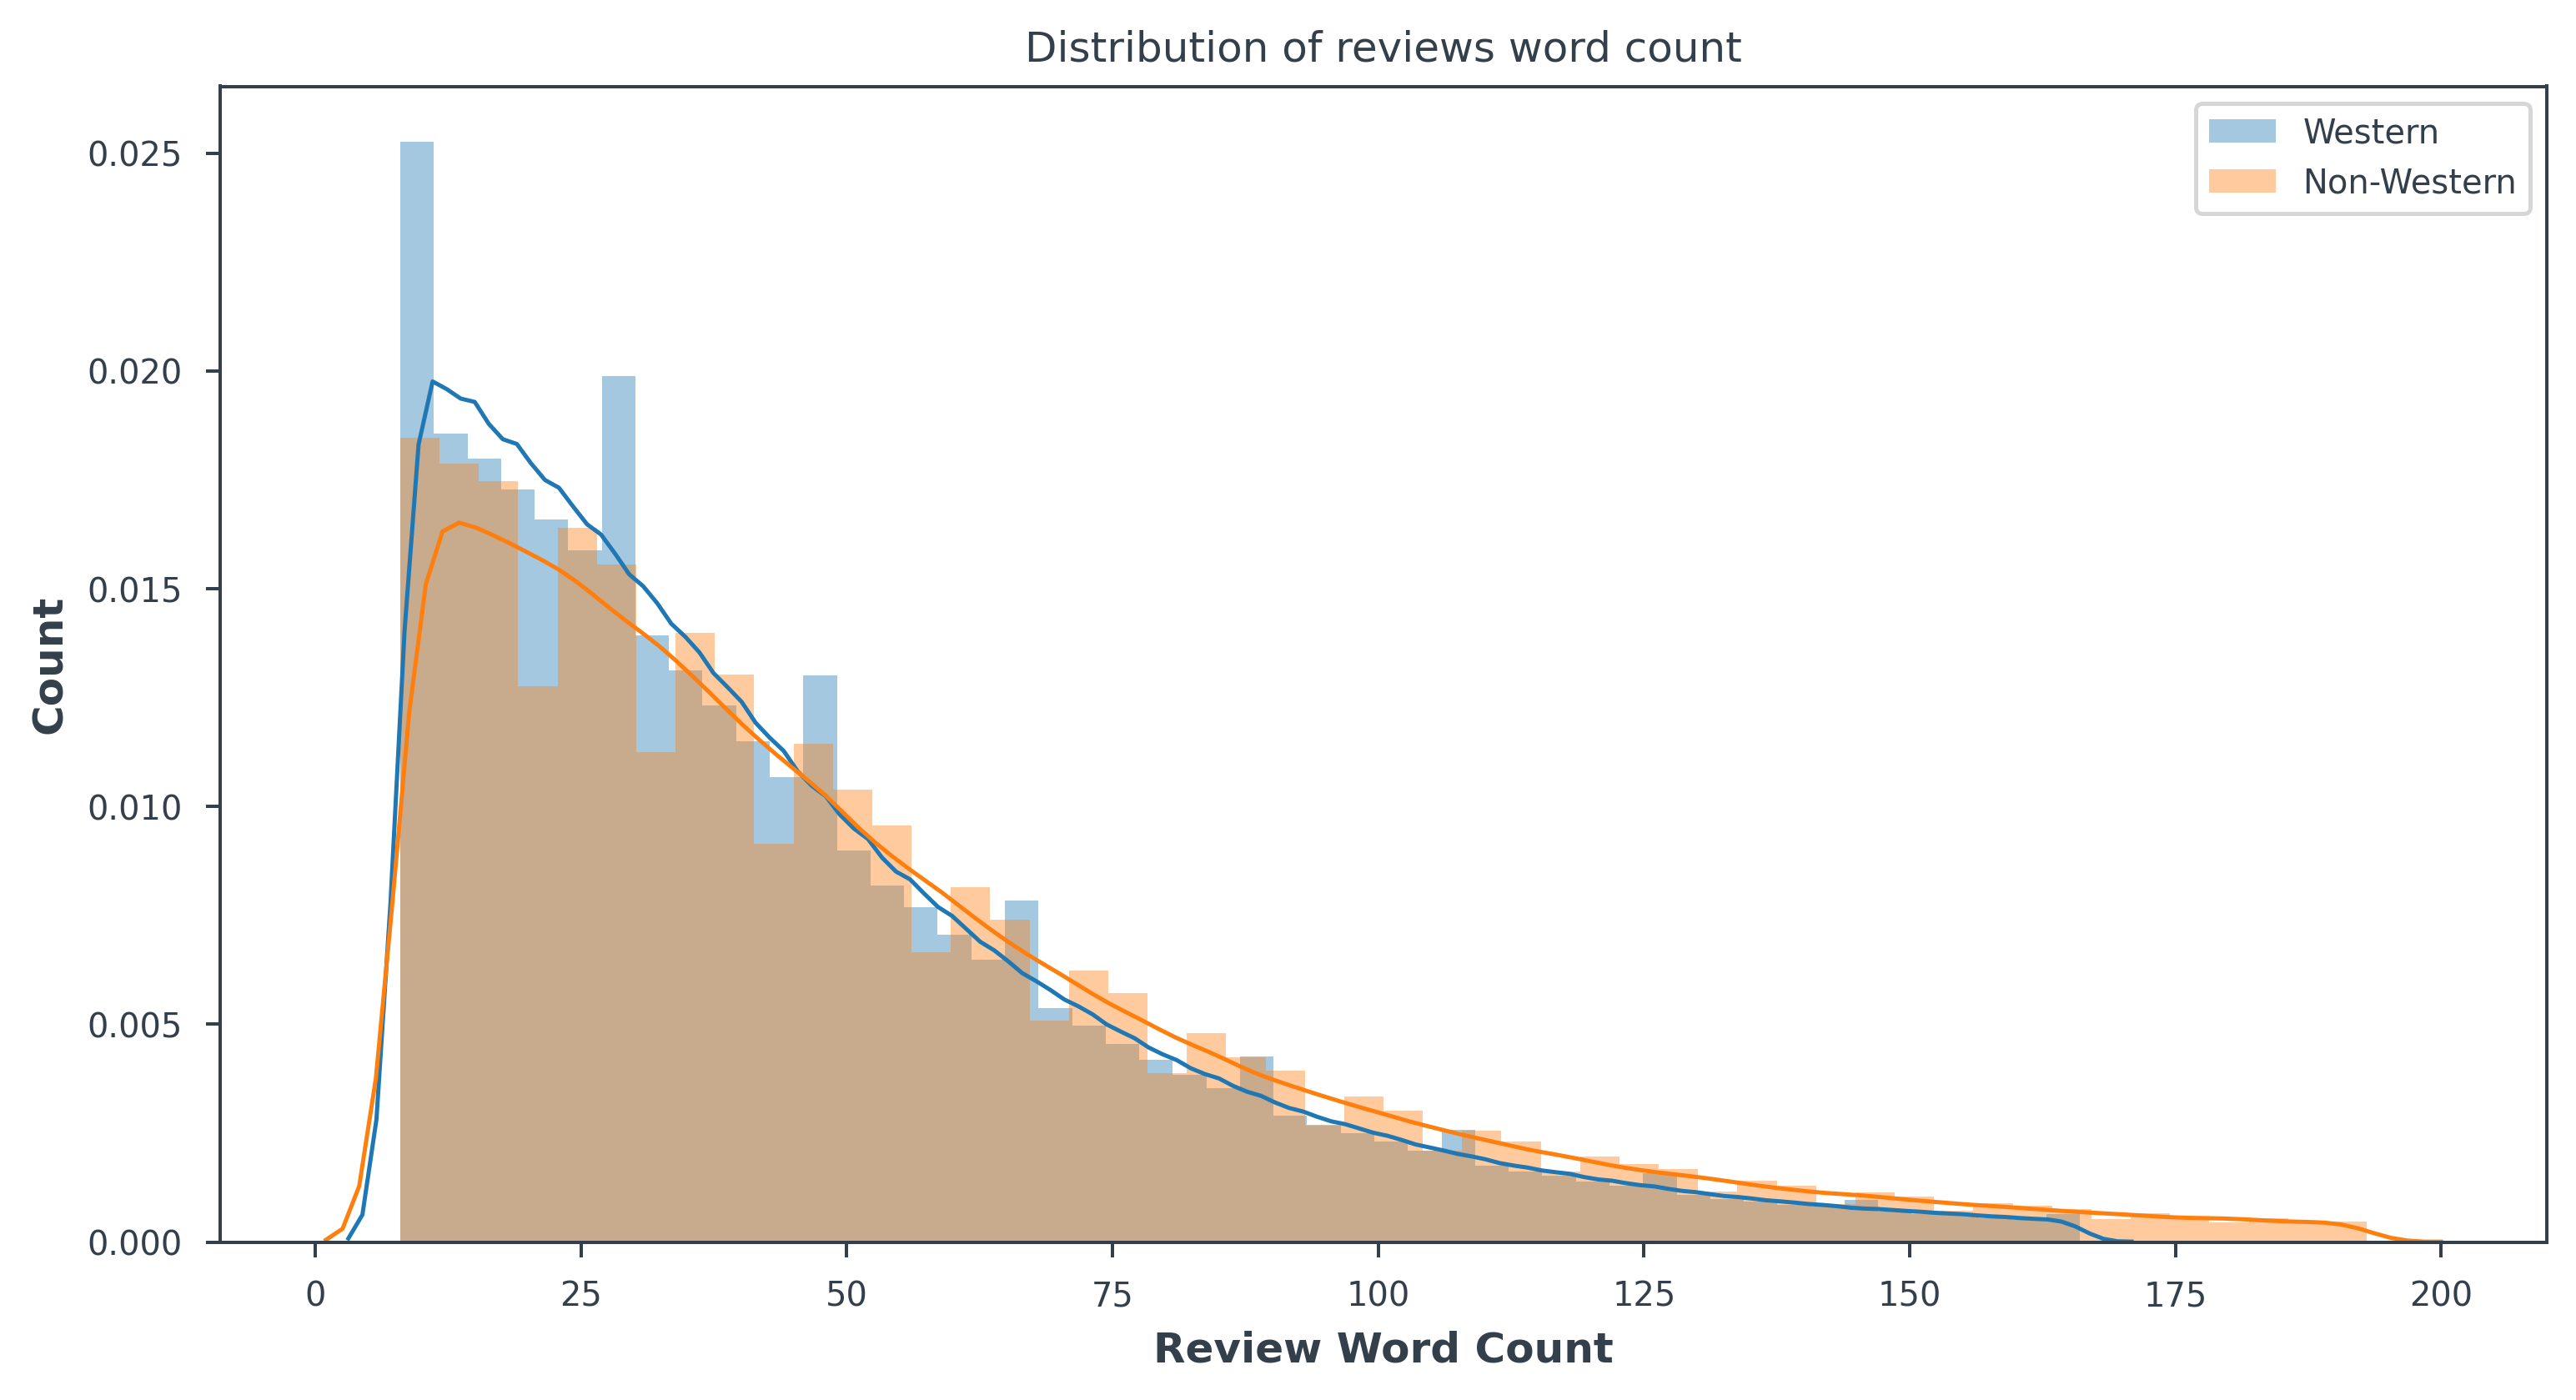

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

sns.distplot(data[data.type=='Western'].review_word_count, bins=50, ax=ax, label='Western')
sns.distplot(data[data.type=='Non-Western'].review_word_count, bins=50, ax=ax, label='Non-Western')

plt.title('Distribution of reviews word count')
plt.xlabel('Review Word Count')
plt.ylabel('Count')
plt.legend()

plt.show();

In [10]:
print('The average number of words in reviews is: {}'.format(round(data.review_word_count.mean())))
print('The minimum number of words in reviews is: {}'.format(min(data.review_word_count)))
print('The maximum number of words in reviews is: {}'.format(max(data.review_word_count)))

The average number of words in reviews is: 47
The minimum number of words in reviews is: 8
The maximum number of words in reviews is: 193


### Bin 'review_word_count' into three discrete set of labels: 'Short', 'Medium' and 'Long' 

In [11]:
bins = [0, 20, 50, 193]
labels = ['Short', 'Medium', 'Long']
data['review_word_bined'] = pd.cut(data['review_word_count'], bins=bins, labels=labels)

In [12]:
data.review_word_bined[data.type=='Western'].value_counts()

Medium    1095560
Long       905072
Short      666727
Name: review_word_bined, dtype: int64

In [13]:
data.review_word_bined[data.type=='Non-Western'].value_counts()

Long      354087
Medium    344596
Short     191357
Name: review_word_bined, dtype: int64

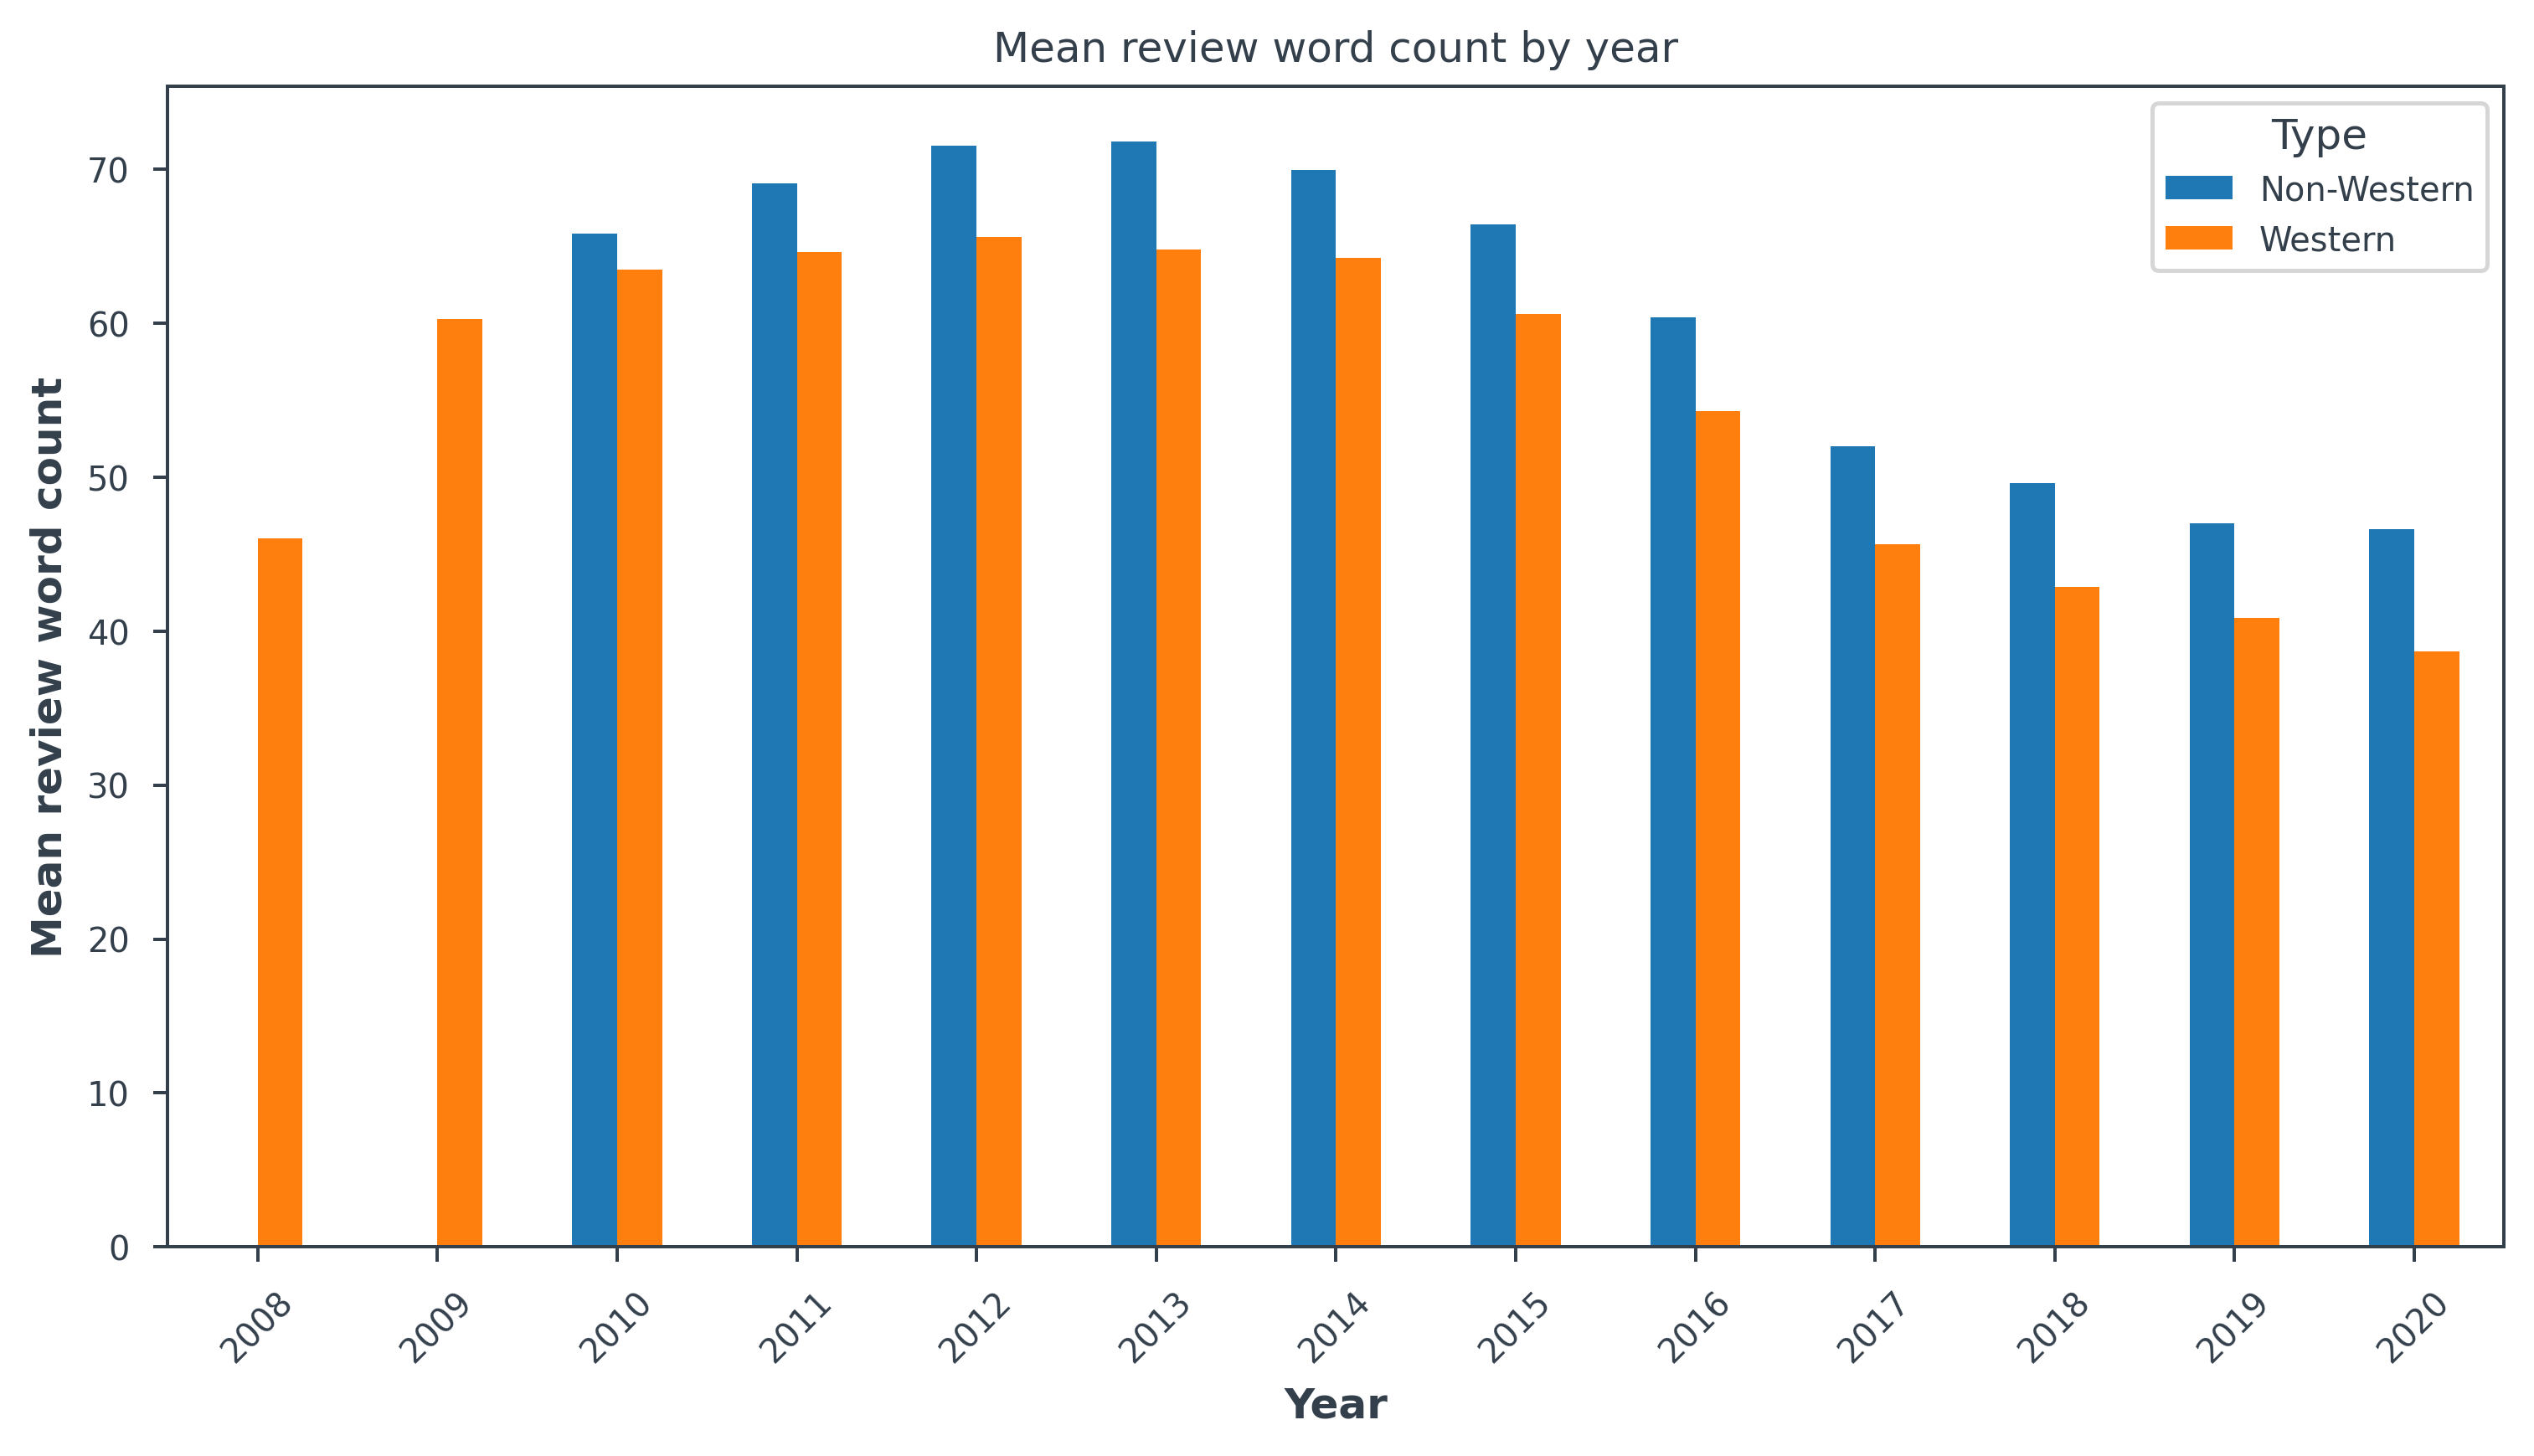

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

data.groupby(['year', 'type'])['review_word_count'].mean().unstack().plot(kind='bar', ax=ax)
plt.title('Mean review word count by year')
plt.legend(title='Type')
plt.xlabel('Year')
plt.ylabel('Mean review word count')
plt.tick_params(axis='x', rotation=45)

plt.show();

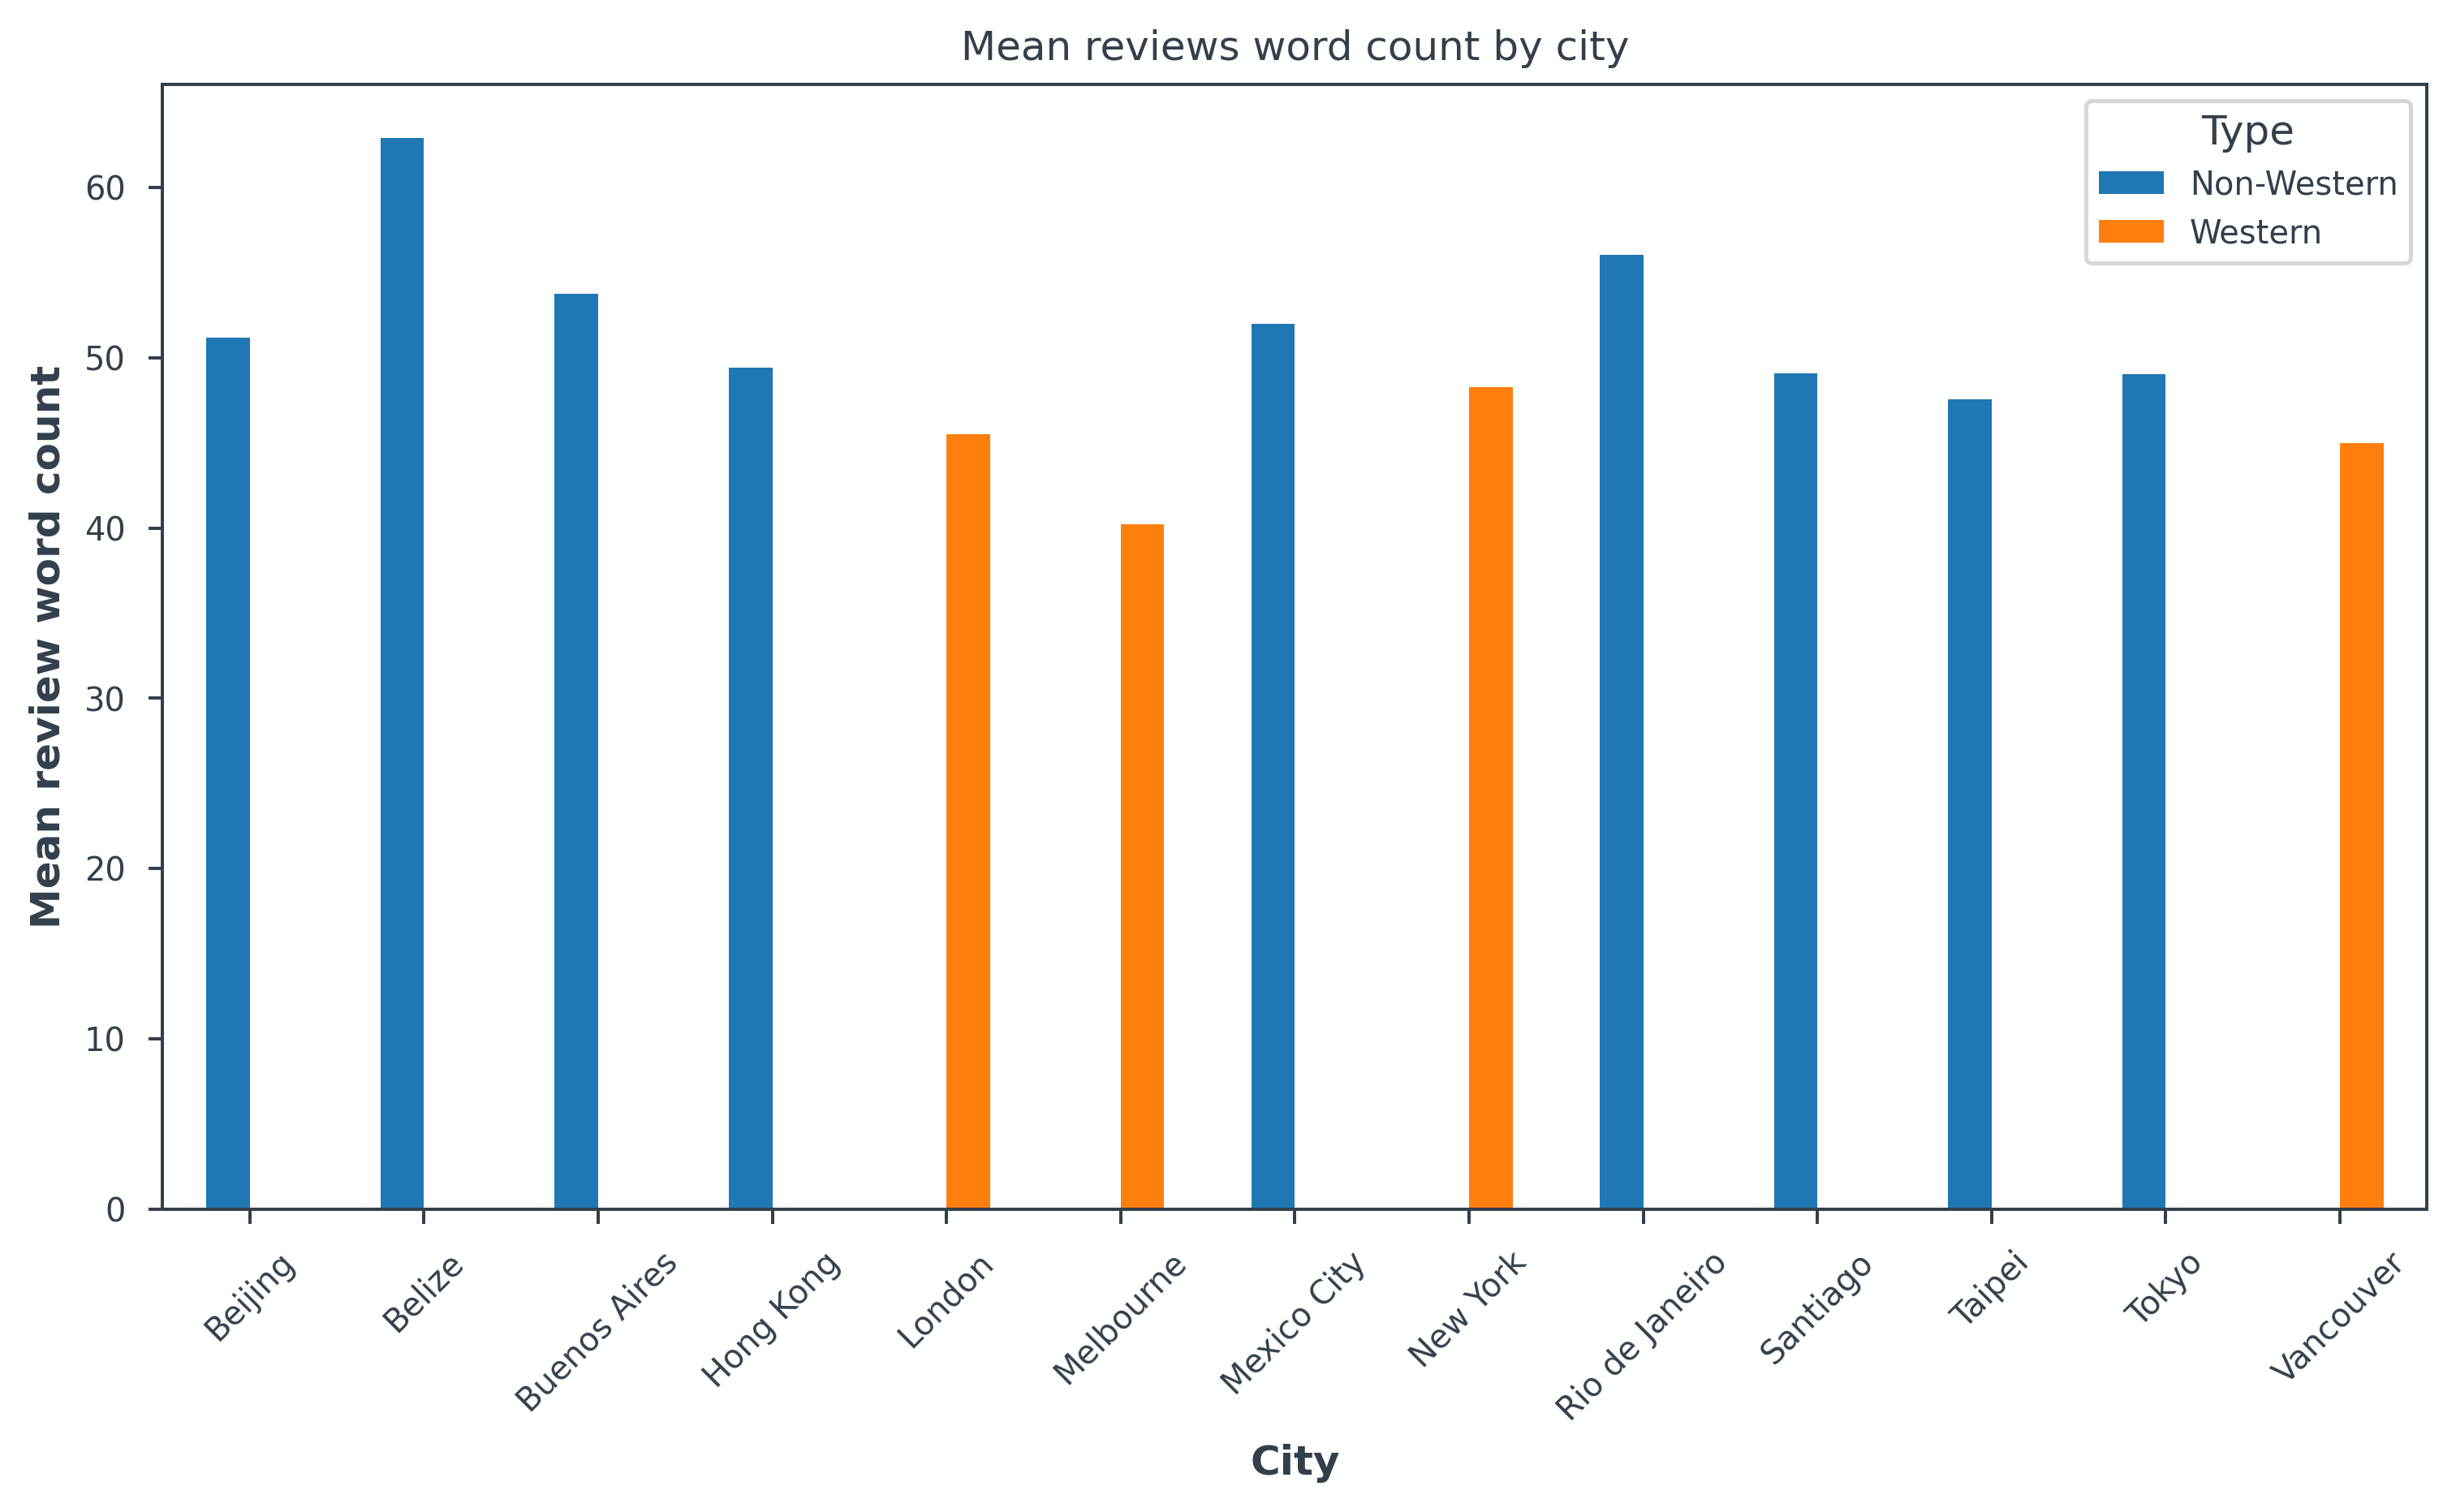

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

data.groupby(['city', 'type'])['review_word_count'].mean().reset_index().pivot('city', 'type', 'review_word_count')\
            .plot(kind='bar', ax=ax,)
plt.title('Mean reviews word count by city')
plt.legend(title='Type')
plt.xlabel('City')
plt.ylabel('Mean review word count')
plt.tick_params(axis='x', rotation=45)

plt.show();

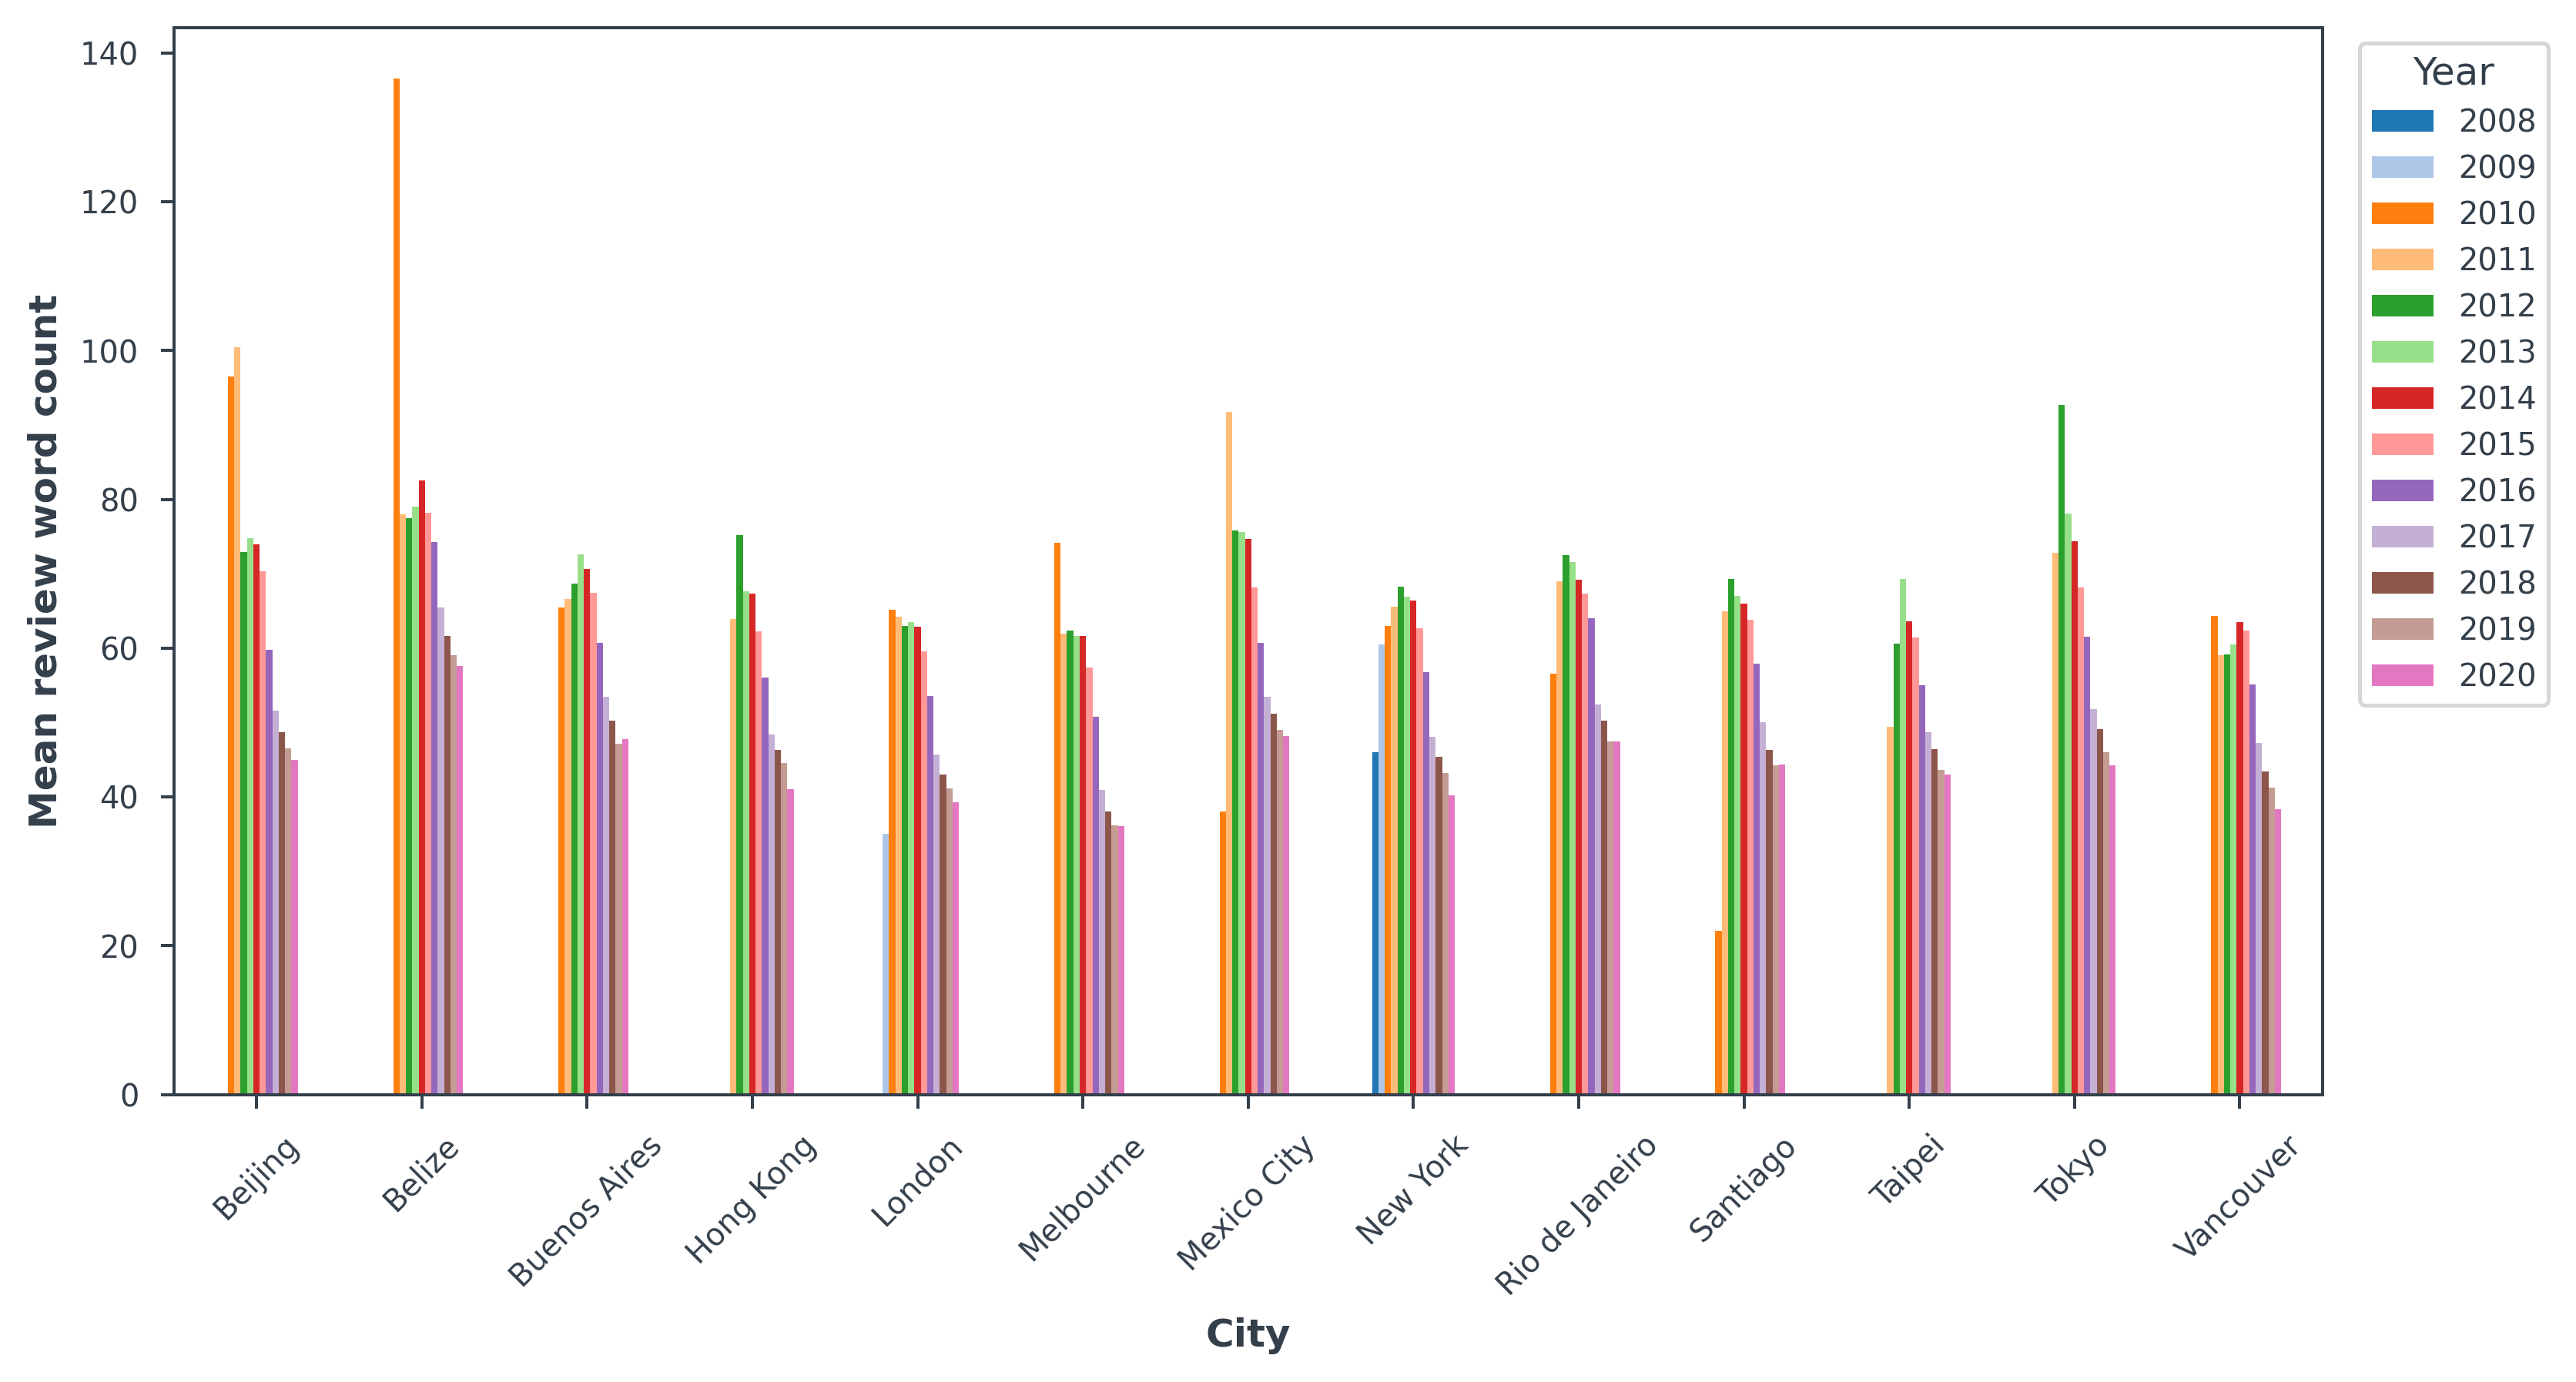

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

data.groupby(['city', 'year'])['review_word_count'].mean().reset_index().pivot('city', 'year', 'review_word_count').plot(kind='bar', ax=ax, color=color)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Year')
plt.xlabel('City')
plt.ylabel('Mean review word count')
plt.tick_params(axis='x', rotation=45)

plt.show();

In [17]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [19]:
#data = stratified_sample_df(data, 'city', 10000)
#print(data.shape)
#data.head()

(130000, 22)


,id,date,comments,host_id,host_since,neighbourhood_cleansed,city,latitude,longitude,number_of_reviews,...,review_scores_rating,probability,language,comments_cleaned,comments_cleaned_sentiment,num_words,year,type,comment_to_sentences,comment_to_sentences_regex
2779359,6914699,2016-03-12,Cozy and charming historical house in the cent...,29544201,2015-03-18,东城区,Beijing,39.94292,116.42102,73,...,97.0,0.999998,en,Cozy and charming historical house in the cent...,Cozy and charming historical house in the cent...,37,2016,non western,[Cozy and charming historical house in the cen...,[Cozy and charming historical house in the cen...
2795589,32997950,2019-07-25,This is a lovely shared apartment. You have yo...,46840971,2015-10-18,东城区,Beijing,39.91785,116.41532,43,...,98.0,0.999995,en,This is a lovely shared apartment You have you...,This is a lovely shared apartment. You have yo...,34,2019,non western,"[This is a lovely shared apartment., You have ...","[This is a lovely shared apartment, You have y..."
2779597,7239103,2016-04-06,"The house is wonderfully designed , especially...",29544201,2015-03-18,东城区,Beijing,39.94314,116.41417,95,...,94.0,0.999999,en,The house is wonderfully designed especially l...,The house is wonderfully designed especially l...,140,2016,non western,[The house is wonderfully designed especially ...,[The house is wonderfully designed especially ...
2797750,39686549,2019-11-11,"Good room, everything seemed clean, enough spa...",209023661,2018-08-12,海淀区,Beijing,39.99353,116.34111,16,...,100.0,0.999997,en,Good room everything seemed clean enough space...,Good room everything seemed clean enough space...,49,2019,non western,[Good room everything seemed clean enough spac...,[Good room everything seemed clean enough spac...
2790780,24239168,2018-07-15,Lu was very welcoming and his command of Engli...,127613055,2017-04-25,西城区,Beijing,39.89151,116.32731,18,...,99.0,0.999997,en,Lu was very welcoming and his command of Engli...,Lu was very welcoming and his command of Engli...,100,2018,non western,[Lu was very welcoming and his command of Engl...,[Lu was very welcoming and his command of Engl...


### Sentence to tokens

In [18]:
data['sentences_to_tokens'] = data['comment_to_sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])

In [19]:
print(data['sentences_to_tokens'].tolist()[:3])

[[['My', 'girlfriend', 'and', 'I', 'had', 'not', 'known', 'Alina', 'before', 'we', 'took', 'the', 'leap', 'of', 'faith', 'to', 'rent', 'her', 'flat', '.'], ['Alina', 'just', 'could', 'not', 'be', 'nicer', '.'], ['Her', 'flat', 'is', 'comfortable', 'homey', 'very', 'sunny', 'and', 'quiet', 'at', 'night', '.'], ['Her', 'diverse', 'neighborhood', 'rocks', '.'], ['it', 'is', 'full', 'of', 'excellent', 'eateries', 'of', 'varying', 'ethnicities', 'good', 'supermarkets', 'etc', '.'], ['etc', '.'], ['Her', 'place', 'is', 'about', 'a', 'minute', 'walk', 'to', 'the', 'Finsbury', 'Park', 'tube', 'stop', 'and', 'there', 'are', 'also', 'several', 'buses', 'that', 'ply', 'Stroud', 'Green', 'Road', '.'], ['The', 'Piccadilly', 'and', 'Victoria', 'tube', 'lines', 'that', 'serve', 'Finsbury', 'Park', 'are', 'very', 'dependable', 'and', 'come', 'frequently', '.'], ['My', 'only', 'caveat', 'is', 'if', 'you', 'are', 'unwilling', 'to', 'take', 'to', 'minute', 'commutes', 'to', 'downtown', 'London', 'attract

In [ ]:
data.to_pickle('data.pkl')

In [116]:
content = data.sentences_to_tokens.values.tolist()

In [117]:
print(content[:10])

[[['Cozy', 'and', 'charming', 'historical', 'house', 'in', 'the', 'center', 'of', 'Beijing'], ['Room', 'is', 'warm', 'and', 'clean', 'the', 'living', 'room', 'is', 'decorated', 'really', 'nice'], ['It', 'is', 'quiet', 'at', 'night', 'suitable', 'for', 'those', 'who', 'are', 'not', 'easy', 'to', 'sleep'], ['gps']], [['This', 'is', 'a', 'lovely', 'shared', 'apartment'], ['You', 'have', 'your', 'individual', 'ensuite'], ['However', 'the', 'kitchen', 'is', 'open', 'to', 'entire', 'hotel'], ['Very', 'modern', 'and', 'clean'], ['Great', 'location', 'only', 'three', 'minutes', 'walking', 'Distance', 'to', 'metro', 'or', 'Wangfujing'], []], [['The', 'house', 'is', 'wonderfully', 'designed', 'especially', 'love', 'the', 'rooftop', 'where', 'me', 'and', 'my', 'friend', 'could', 'just', 'chill', 'under', 'the', 'sun'], ['Chiyi', 's', 'parents', 'are', 'the', 'most', 'lovely', 'and', 'gave', 'us', 'a', 'real', 'taste', 'of', 'Beijing', 'neighbourhood'], ['Their', 'buns', 'for', 'breakfast', 'were'

In [118]:
content = [sentence for sentences in content for sentence in sentences]

In [119]:
print(content[:10])

[['Cozy', 'and', 'charming', 'historical', 'house', 'in', 'the', 'center', 'of', 'Beijing'], ['Room', 'is', 'warm', 'and', 'clean', 'the', 'living', 'room', 'is', 'decorated', 'really', 'nice'], ['It', 'is', 'quiet', 'at', 'night', 'suitable', 'for', 'those', 'who', 'are', 'not', 'easy', 'to', 'sleep'], ['gps'], ['This', 'is', 'a', 'lovely', 'shared', 'apartment'], ['You', 'have', 'your', 'individual', 'ensuite'], ['However', 'the', 'kitchen', 'is', 'open', 'to', 'entire', 'hotel'], ['Very', 'modern', 'and', 'clean'], ['Great', 'location', 'only', 'three', 'minutes', 'walking', 'Distance', 'to', 'metro', 'or', 'Wangfujing'], []]


In [120]:
with open('content.pkl', 'wb') as f:
    pickle.dump(content, f)

In [98]:
def sent_to_words(doc):
    for sentences in doc:
        for sentence in sentences:
            return (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [5]:
with open('content.pkl', 'rb') as f:
    content = pickle.load(f)

In [26]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist

def freq_words(content):
    all_words = [word for text in content for sentence in text for word in sentence]
    freq_dist = FreqDist(all_words)
    return freq_dist

In [27]:
%%time
words_freq = freq_words(data['sentences_to_tokens_regex'])

CPU times: user 6.01 s, sys: 51.2 ms, total: 6.06 s
Wall time: 6.07 s


In [21]:
with open('words_freq.pkl', 'wb') as f:
    pickle.dump(words_freq, f)

In [28]:
# function to plot most frequent terms
def plot_freq_words(fdist, terms = 20):
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns='count', n = terms) 
    plt.figure(figsize=(20,7))
    plt.tick_params(labelsize=12)
    ax = sns.barplot(data=d, x= 'word', y = 'count')
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xlabel('Word', fontsize=14)
    plt.title('Most frequent words', fontdict=dict(size=20))
    plt.show()

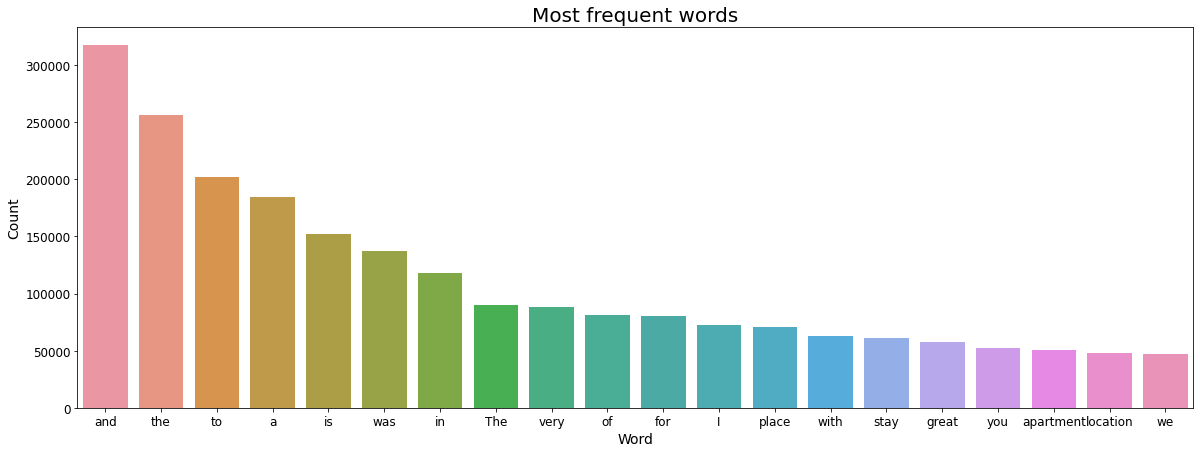

In [29]:
plot_freq_words(words_freq, 20)

In [61]:
def lemmatization(texts, allowed_postags=['NOUN', 'VERB']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_.lower() for token in doc 
                          if token.is_stop != True 
                          and token.is_alpha == True
                          and token.is_punct != True 
                          and token.pos_ in allowed_postags
                         and len(token)>1])
    return texts_out

In [64]:
%%time
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser'])

# Do lemmatization keeping only noun, adj, vb, adv
data['tokens_lemmatized'] = data['sentences_to_tokens_regex'].map(lambda sentences: lemmatization(sentences, 
                                                                    allowed_postags=['NOUN', 'VERB']))


CPU times: user 1h 9min 26s, sys: 4.25 s, total: 1h 9min 31s
Wall time: 1h 9min 37s


In [72]:
data['tokens_lemmatized'].tolist()[:5]

[[['cozy', 'charm', 'historical', 'house', 'center'],
  ['room', 'warm', 'clean', 'living', 'room', 'decorate', 'nice'],
  ['quiet', 'night', 'suitable', 'easy', 'sleep'],
  []],
 [['lovely', 'share', 'apartment'],
  ['individual', 'ensuite'],
  ['kitchen', 'open', 'entire', 'hotel'],
  ['modern', 'clean'],
  ['great', 'location', 'minute', 'walk'],
  []],
 [['house',
   'wonderfully',
   'design',
   'especially',
   'love',
   'rooftop',
   'friend',
   'chill',
   'sun'],
  ['parent', 'lovely', 'give', 'real', 'taste', 'neighbourhood'],
  ['bun', 'breakfast', 'great'],
  ['free', 'use', 'kitchen', 'amenity', 'dumpling', 'oatmeal', 'fruit'],
  ['ready', 'breakfast', 'thoughtful'],
  ['small', 'hassle', 'check', 'immediately', 'go', 'way', 'hour', 'journey'],
  ['feel', 'sorry', 'appreciate', 'effort'],
  ['effective', 'arrangement', 'prevent'],
  [],
  ['locker', 'password', 'store', 'key', 'emergency'],
  ['highly',
   'recommend',
   'place',
   'great',
   'hospitality',
   'locat

In [74]:
data_lemmatized = data['tokens_lemmatized'].tolist()

In [75]:
data_words =  [sentence for sentences in data_lemmatized for sentence in sentences]

In [76]:
data_words

[['cozy', 'charm', 'historical', 'house', 'center'],
 ['room', 'warm', 'clean', 'living', 'room', 'decorate', 'nice'],
 ['quiet', 'night', 'suitable', 'easy', 'sleep'],
 [],
 ['lovely', 'share', 'apartment'],
 ['individual', 'ensuite'],
 ['kitchen', 'open', 'entire', 'hotel'],
 ['modern', 'clean'],
 ['great', 'location', 'minute', 'walk'],
 [],
 ['house',
  'wonderfully',
  'design',
  'especially',
  'love',
  'rooftop',
  'friend',
  'chill',
  'sun'],
 ['parent', 'lovely', 'give', 'real', 'taste', 'neighbourhood'],
 ['bun', 'breakfast', 'great'],
 ['free', 'use', 'kitchen', 'amenity', 'dumpling', 'oatmeal', 'fruit'],
 ['ready', 'breakfast', 'thoughtful'],
 ['small', 'hassle', 'check', 'immediately', 'go', 'way', 'hour', 'journey'],
 ['feel', 'sorry', 'appreciate', 'effort'],
 ['effective', 'arrangement', 'prevent'],
 [],
 ['locker', 'password', 'store', 'key', 'emergency'],
 ['highly',
  'recommend',
  'place',
  'great',
  'hospitality',
  'location',
  'heart',
  'tourist',
  'att

In [77]:
print(data['sentences_to_tokens_regex'].to_list()[:3])

[[['Cozy', 'and', 'charming', 'historical', 'house', 'in', 'the', 'center', 'of', 'Beijing'], ['Room', 'is', 'warm', 'and', 'clean', 'the', 'living', 'room', 'is', 'decorated', 'really', 'nice'], ['It', 'is', 'quiet', 'at', 'night', 'suitable', 'for', 'those', 'who', 'are', 'not', 'easy', 'to', 'sleep'], ['gps']], [['This', 'is', 'a', 'lovely', 'shared', 'apartment'], ['You', 'have', 'your', 'individual', 'ensuite'], ['However', 'the', 'kitchen', 'is', 'open', 'to', 'entire', 'hotel'], ['Very', 'modern', 'and', 'clean'], ['Great', 'location', 'only', 'three', 'minutes', 'walking', 'Distance', 'to', 'metro', 'or', 'Wangfujing'], []], [['The', 'house', 'is', 'wonderfully', 'designed', 'especially', 'love', 'the', 'rooftop', 'where', 'me', 'and', 'my', 'friend', 'could', 'just', 'chill', 'under', 'the', 'sun'], ['Chiyi', 's', 'parents', 'are', 'the', 'most', 'lovely', 'and', 'gave', 'us', 'a', 'real', 'taste', 'of', 'Beijing', 'neighbourhood'], ['Their', 'buns', 'for', 'breakfast', 'were'

In [78]:
print(data['tokens_lemmatized'].tolist()[:3])

[[['cozy', 'charm', 'historical', 'house', 'center'], ['room', 'warm', 'clean', 'living', 'room', 'decorate', 'nice'], ['quiet', 'night', 'suitable', 'easy', 'sleep'], []], [['lovely', 'share', 'apartment'], ['individual', 'ensuite'], ['kitchen', 'open', 'entire', 'hotel'], ['modern', 'clean'], ['great', 'location', 'minute', 'walk'], []], [['house', 'wonderfully', 'design', 'especially', 'love', 'rooftop', 'friend', 'chill', 'sun'], ['parent', 'lovely', 'give', 'real', 'taste', 'neighbourhood'], ['bun', 'breakfast', 'great'], ['free', 'use', 'kitchen', 'amenity', 'dumpling', 'oatmeal', 'fruit'], ['ready', 'breakfast', 'thoughtful'], ['small', 'hassle', 'check', 'immediately', 'go', 'way', 'hour', 'journey'], ['feel', 'sorry', 'appreciate', 'effort'], ['effective', 'arrangement', 'prevent'], [], ['locker', 'password', 'store', 'key', 'emergency'], ['highly', 'recommend', 'place', 'great', 'hospitality', 'location', 'heart', 'tourist', 'attraction'], []]]


In [137]:
data.head()

,id,date,comments,host_id,host_since,neighbourhood_cleansed,city,latitude,longitude,number_of_reviews,...,comments_cleaned_sentiment,num_words,year,type,comment_to_sentences,comment_to_sentences_regex,sentences_to_tokens,sentences_to_tokens_regex,token_lemmatized,tokens_lemmatized
2779359,6914699,2016-03-12,Cozy and charming historical house in the cent...,29544201,2015-03-18,东城区,Beijing,39.94292,116.42102,73,...,Cozy and charming historical house in the cent...,37,2016,non western,[Cozy and charming historical house in the cen...,[Cozy and charming historical house in the cen...,"[[Cozy, and, charming, historical, house, in, ...","[[Cozy, and, charming, historical, house, in, ...","[[[cozy, charm, historical, house, center]], [...","[[cozy, charm, historical, house, center], [ro..."
2795589,32997950,2019-07-25,This is a lovely shared apartment. You have yo...,46840971,2015-10-18,东城区,Beijing,39.91785,116.41532,43,...,This is a lovely shared apartment. You have yo...,34,2019,non western,"[This is a lovely shared apartment., You have ...","[This is a lovely shared apartment, You have y...","[[This, is, a, lovely, shared, apartment, .], ...","[[This, is, a, lovely, shared, apartment], [Yo...","[[[lovely, share, apartment]], [[individual, e...","[[lovely, share, apartment], [individual, ensu..."
2779597,7239103,2016-04-06,"The house is wonderfully designed , especially...",29544201,2015-03-18,东城区,Beijing,39.94314,116.41417,95,...,The house is wonderfully designed especially l...,140,2016,non western,[The house is wonderfully designed especially ...,[The house is wonderfully designed especially ...,"[[The, house, is, wonderfully, designed, espec...","[[The, house, is, wonderfully, designed, espec...","[[[house, wonderfully, design, especially, lov...","[[house, wonderfully, design, especially, love..."
2797750,39686549,2019-11-11,"Good room, everything seemed clean, enough spa...",209023661,2018-08-12,海淀区,Beijing,39.99353,116.34111,16,...,Good room everything seemed clean enough space...,49,2019,non western,[Good room everything seemed clean enough spac...,[Good room everything seemed clean enough spac...,"[[Good, room, everything, seemed, clean, enoug...","[[Good, room, everything, seemed, clean, enoug...","[[[good, room, clean, space, people, big, soli...","[[good, room, clean, space, people, big, solid..."
2790780,24239168,2018-07-15,Lu was very welcoming and his command of Engli...,127613055,2017-04-25,西城区,Beijing,39.89151,116.32731,18,...,Lu was very welcoming and his command of Engli...,100,2018,non western,[Lu was very welcoming and his command of Engl...,[Lu was very welcoming and his command of Engl...,"[[Lu, was, very, welcoming, and, his, command,...","[[Lu, was, very, welcoming, and, his, command,...","[[[welcoming, command, mean, good, host, forei...","[[welcoming, command, mean, good, host, foreig..."


In [138]:
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [39]:
#stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
#stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
#my_stopwords = stopwords.words('English')

In [79]:
%%time
#Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(bigram_mod[data_words[0]])
print(trigram_mod[data_words[0]])

['cozy', 'charm', 'historical', 'house', 'center']
['cozy', 'charm', 'historical', 'house', 'center']
CPU times: user 51.2 s, sys: 493 ms, total: 51.7 s
Wall time: 51.8 s


In [80]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [81]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [82]:
%%time
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
data_words_trigrams = make_trigrams(make_bigrams(data_words))
print(data_words_trigrams[:10])

[['cozy', 'charm', 'historical', 'house', 'center'], ['room', 'warm', 'clean', 'living_room', 'decorate', 'nice'], ['quiet', 'night', 'suitable', 'easy', 'sleep'], [], ['lovely', 'share', 'apartment'], ['individual', 'ensuite'], ['kitchen', 'open', 'entire', 'hotel'], ['modern', 'clean'], ['great', 'location', 'minute_walk'], []]
CPU times: user 52.5 s, sys: 757 ms, total: 53.3 s
Wall time: 53.4 s


In [83]:
with open('token.pkl', 'wb') as f:
    pickle.dump(data_words_trigrams, f)

In [84]:
words_freq = dict()
for doc in data_words_trigrams:
    for word in doc:
        if word in words_freq:
            words_freq[word] = words_freq[word] + 1
        else:
            words_freq[word] = 1

In [85]:
import operator
dict(sorted(words_freq.items(), key=operator.itemgetter(1),reverse=True))

{'stay': 79738,
 'place': 77959,
 'great': 76820,
 'apartment': 52538,
 'location': 52252,
 'host': 43259,
 'clean': 40529,
 'good': 37038,
 'nice': 34253,
 'room': 25379,
 'need': 23446,
 'close': 22554,
 'comfortable': 21471,
 'time': 20375,
 'perfect': 19198,
 'recommend': 18096,
 'helpful': 17830,
 'definitely': 16511,
 'easy': 14818,
 'restaurant': 14358,
 'area': 14029,
 'thank': 14028,
 'house': 13873,
 'amazing': 13569,
 'check': 13306,
 'highly_recommend': 12060,
 'friendly': 12060,
 'super': 12054,
 'lot': 11899,
 'day': 11502,
 'lovely': 11276,
 'love': 11229,
 'space': 10858,
 'quiet': 10810,
 'enjoy': 10727,
 'beautiful': 10528,
 'home': 10429,
 'night': 10426,
 'wonderful': 10384,
 'come': 10203,
 'convenient': 10019,
 'experience': 9709,
 'walk': 9624,
 'bed': 9509,
 'city': 9055,
 'small': 9024,
 'excellent': 8912,
 'locate': 8782,
 'neighborhood': 8655,
 'help': 8515,
 'provide': 8160,
 'view': 8157,
 'station': 7978,
 'little': 7949,
 'spacious': 7764,
 'visit': 7733,

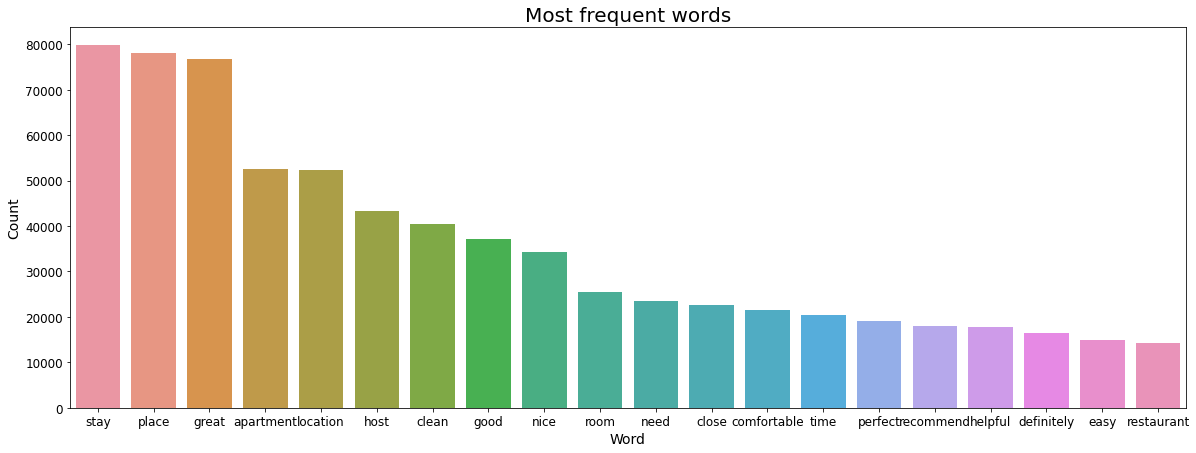

In [86]:
plot_freq_words(words_freq, 20)

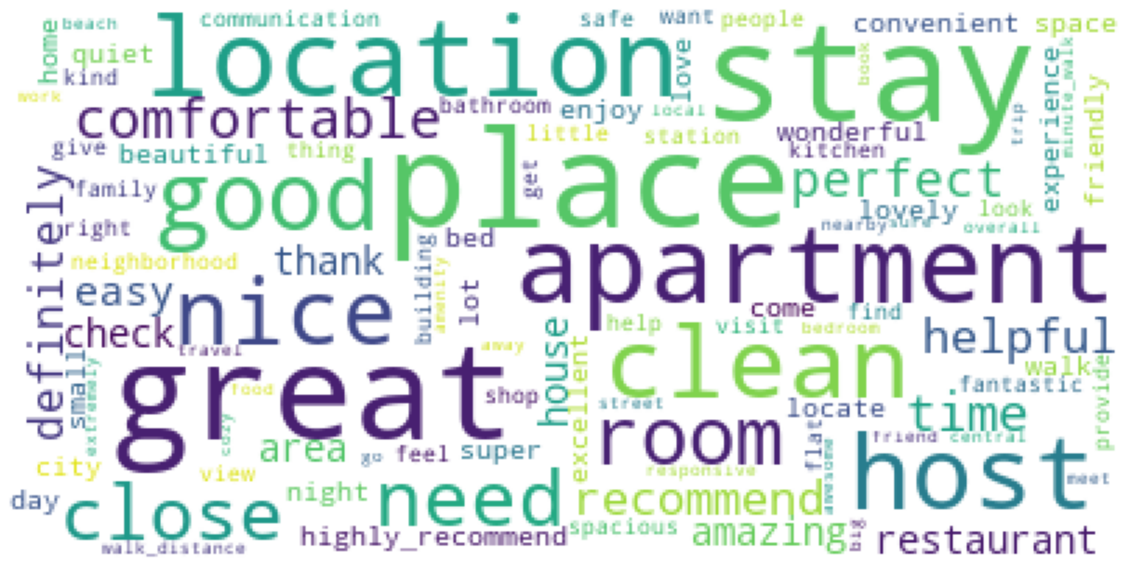

In [87]:
#Word cloud
from wordcloud import WordCloud, ImageColorGenerator

#words = ''
#for doc in data_lemmatized:
    #words = words + ' ' + ' '.join([text for text in doc])
    
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      max_font_size=50,
                      random_state=42).generate_from_frequencies(words_freq)
#print(wordcloud)
fig = plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [90]:
allWordDist = FreqDist(sentence for sentences in data_words_trigrams for sentence in sentences)

In [92]:
allWordDist

FreqDist({'stay': 79738, 'place': 77959, 'great': 76820, 'apartment': 52538, 'location': 52252, 'host': 43259, 'clean': 40529, 'good': 37038, 'nice': 34253, 'room': 25379, ...})

In [93]:
mostCommon= allWordDist.most_common(10)
mostCommon

[('stay', 79738),
 ('place', 77959),
 ('great', 76820),
 ('apartment', 52538),
 ('location', 52252),
 ('host', 43259),
 ('clean', 40529),
 ('good', 37038),
 ('nice', 34253),
 ('room', 25379)]